In [202]:
from importlib import reload
import cpclasses
reload(cpclasses)
from cpclasses import *
import torch



In [203]:
class SpringSystem(torch.nn.Module):

    def __init__(self, N, P0, P1, equilibrium_length = 1, spring_constant = 2):
        super().__init__()
        pos = torch.rand(N, 2) * 5
        pos[0,:] = torch.tensor(P0)
        pos[-1,:] = torch.tensor(P1)

        self.pos = torch.nn.Parameter(pos)
        


        self._mask = torch.zeros_like(pos)
        self._mask[1:-1, :] = 1.0
        self.equilibrium_length = equilibrium_length
        self.spring_constant = spring_constant
        self.m = torch.ones(pos.shape[0])
        
    def forward(self):
        spring_energy = torch.sum(self._spring_energy())
        gravitational_energy = torch.sum(self._gravitational_energy())

        return spring_energy + gravitational_energy


    def _spring_energy(self):
        
        total_energy = 0
        for n in range(len(self.pos) - 1):
            pos_i = self.pos[n]
            pos_j = self.pos[n+1]

            total_energy += 0.5 * self.spring_constant * (torch.norm(pos_i - pos_j) - self.equilibrium_length)**2
    
        return total_energy

    def _gravitational_energy(self):
        g = 9.82
        energies = self.m * g * self.pos[:,1]
        energy = torch.sum(energies)
        return energy

    def mask(self):
        with torch.no_grad():
            self.pos.grad *= self._mask


    def plot(self, ax, alpha = 1, color = 'C0'):
        colors = [color for i in range(len(self.pos))]
        colors[0] = 'C1'
        colors[-1] = 'C1'
        ax.plot(self.pos[:,0], self.pos[:,1], '-')
        ax.scatter(self.pos[:,0], self.pos[:,1], s = 100, color = colors, alpha = alpha)
        

        return ax


    

In [204]:


spring = SpringSystem(5, [0.,0.], [5.,0.])

print(f'Spring energy: {spring._spring_energy()}')
print(f'Gravitational energy: {spring._gravitational_energy()}')
print(f'Total energy: {spring()}')






Spring energy: 28.580318450927734
Gravitational energy: 20.704668045043945
Total energy: 49.28498840332031


Parameter containing:
tensor([[0.0000, 0.0000],
        [1.9948, 3.5223],
        [2.2876, 0.6844],
        [2.6276, 0.0950],
        [3.5176, 2.8575],
        [5.0000, 0.0000]], requires_grad=True)


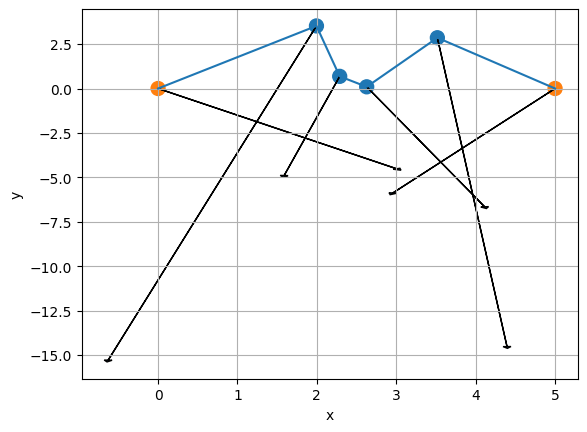

In [205]:
fig, ax = plt.subplots()
format_axis(ax, legend=False)

spring = SpringSystem(6, [0.,0.], [5.,0.])
print(spring.pos)
spring().backward()




with torch.no_grad():
    spring.plot(ax)

    for pos, grad in zip(spring.pos, spring.pos.grad):
        ax.arrow(pos[0], pos[1], -grad[0], -grad[1], head_width=0.1, head_length=0.1)
    
    #ax.plot(x, yp)



In [206]:
optimizer = torch.optim.Adam(spring.parameters(), lr=0.1)
steps = 10000

for step in range(steps):
    optimizer.zero_grad()
    energy = spring._spring_energy()
    energy.backward()
    spring.mask()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Step {step}, Loss: {energy.item()}')

Step 0, Loss: 21.368383407592773
Step 1000, Loss: 4.2122981540160254e-05
Step 2000, Loss: 3.838949851342477e-06
Step 3000, Loss: 7.612647436872066e-07
Step 4000, Loss: 0.002841894282028079
Step 5000, Loss: 6.452185630223539e-08
Step 6000, Loss: 6.638214244958363e-07
Step 7000, Loss: 0.0006642147782258689
Step 8000, Loss: 1.4602594688994941e-08
Step 9000, Loss: 3.395635417291487e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[(-0.1, 5.1), (-0.5, 0.5)]

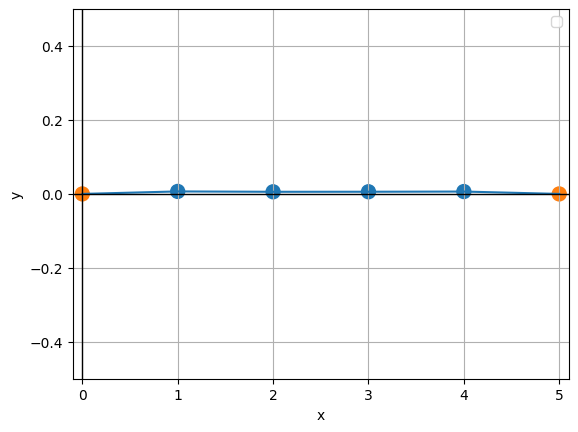

In [207]:
fig, ax = plt.subplots()

with torch.no_grad():
    spring.plot(ax)
    #ax.plot(x, yp)



coordinate_axes(ax)
format_axis(ax)
ax.set(xlim = (-0.1, 5.1), ylim = (-0.5, 0.5))

In [208]:
spring = SpringSystem(11, [0.,0.], [5.,0.])

optimizer = torch.optim.Adam(spring.parameters(), lr=0.5)
steps = 1000

for step in range(steps):
    optimizer.zero_grad()
    energy = spring()
    energy.backward()
    spring.mask()
    optimizer.step()
    if step % 10 == 0:
        print(f'Step {step}, Loss: {energy.item()}')
    print(f'{torch.norm(spring.pos.grad)}')

print(spring.pos.grad)


Step 0, Loss: 326.7641296386719
36.6857795715332
33.7355842590332
32.003570556640625
31.06725311279297
30.64781379699707
30.48537826538086
30.50116539001465
30.506744384765625
30.404905319213867
30.08842658996582
Step 10, Loss: -141.91539001464844
29.427339553833008
28.822505950927734
28.403934478759766
28.158451080322266
28.0045223236084
27.847612380981445
27.645183563232422
27.42019271850586
27.240354537963867
27.16802215576172
Step 20, Loss: -512.0171508789062
27.137371063232422
26.83868408203125
26.58049774169922
26.432161331176758
26.27287483215332
26.09246826171875
25.867294311523438
25.559738159179688
25.174301147460938
24.75672721862793
Step 30, Loss: -831.9380493164062
24.374574661254883
24.088045120239258
23.90921974182129
23.789745330810547
23.663532257080078
23.49783706665039
23.30238914489746
23.106182098388672
22.928518295288086
22.761241912841797
Step 40, Loss: -1101.16845703125
22.575597763061523
22.349597930908203
22.08946418762207
21.826038360595703
21.592466354370117

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='x', ylabel='y'>

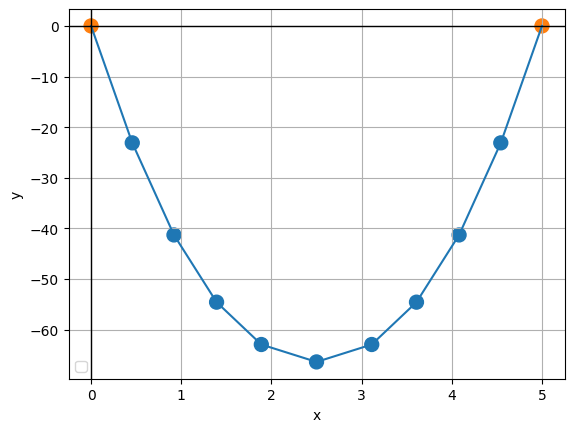

In [209]:
fig, ax = plt.subplots()

with torch.no_grad():
    spring.plot(ax)
    #ax.plot(x, yp)



coordinate_axes(ax)
format_axis(ax)
#ax.set(xlim = (-0.1, 5.1), ylim = (-0.5, 0.5))

In [237]:
def update(i):
    ax.clear()
    
    for spring, color in zip(springs, colors):
        with torch.no_grad():
            spring.plot(ax, alpha = 0.5, color = color)
        optimizer = torch.optim.Adam(spring.parameters(), lr=0.5)
        steps = 10

        for step in range(steps):
            optimizer.zero_grad()
            energy = spring()
            energy.backward()
            spring.mask()
            if torch.norm(spring.pos.grad) >  5*1e0:
                optimizer.step()
            else:
                pass
       
    
    format_axis(ax, legend = False)
    ax.set(xlim = (-0.1, 5.1), ylim = (-45, 0.5))



In [239]:
from matplotlib.animation import FuncAnimation
nodes = [5, 6, 7, 8, 9, 10, 11, 12, 13]
springs = []
colors = []
for node in nodes:
    springs.append(SpringSystem(node, [0.,0.], [5.,0.], spring_constant= 5))
    colors.append(np.random.rand(3))

ani = FuncAnimation(fig, update, frames=range(30), repeat=True)
ani.save('Figures/Catenary.gif', writer='pillow', fps=10)

: 